# Customer Feedback - EDA 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
import re
import string
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/customer-feedback-dataset/sentiment-analysis.csv


# Loading the Data

In [2]:
data=pd.read_csv('/kaggle/input/customer-feedback-dataset/sentiment-analysis.csv')
data.head()

,"Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score"
0,"""I love this product!"", Positive, Twitter, 202..."
1,"""The service was terrible."", Negative, Yelp Re..."
2,"""This movie is amazing!"", Positive, IMDb, 2023..."
3,"""I'm so disappointed with their customer suppo..."
4,"""Just had the best meal of my life!"", Positive..."


In [3]:
#separating the data into columns
data=data['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'].str.split(',', expand=True)
data.columns=['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']

In [4]:
print('There are {} rows and {} columns in data.'.format(data.shape[0], data.shape[1]))

There are 98 rows and 7 columns in data.


In [5]:
data.head(10)

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88
5,"""The quality of this product is subpar.""",Negative,Amazon Reviews,2023-06-16 10:15:27,shopper123,San Francisco,0.72
6,"""I can't stop listening to this song. It's inc...",Positive,Spotify,2023-06-16 13:40:18,musiclover456,Berlin,0.91
7,"""Their website is so user-friendly. Love it!""",Positive,Website Testimonial,2023-06-16 16:05:36,testimonialuser1,Sydney,0.87
8,"""I loved the movie! It was fantastic!""",Positive,IMDb,2023-07-02 09:12:34,user123,New York,0.92
9,"""The customer service was terrible.""",Negative,Yelp Reviews,2023-07-02 10:45:21,user456,Los Angeles,0.65


The data consists of reviews covering various services and products, such as movies, food, and websites. These reviews are categorized into positive and negative sentiments.

# Data Cleaning

In [6]:
data.isnull().sum()

Text                2
Sentiment           2
Source              2
Date/Time           2
User ID             2
Location            2
Confidence Score    2
dtype: int64

In [7]:
data.dropna(inplace=True)

In [8]:
data.head(10)

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88
5,"""The quality of this product is subpar.""",Negative,Amazon Reviews,2023-06-16 10:15:27,shopper123,San Francisco,0.72
6,"""I can't stop listening to this song. It's inc...",Positive,Spotify,2023-06-16 13:40:18,musiclover456,Berlin,0.91
7,"""Their website is so user-friendly. Love it!""",Positive,Website Testimonial,2023-06-16 16:05:36,testimonialuser1,Sydney,0.87
8,"""I loved the movie! It was fantastic!""",Positive,IMDb,2023-07-02 09:12:34,user123,New York,0.92
9,"""The customer service was terrible.""",Negative,Yelp Reviews,2023-07-02 10:45:21,user456,Los Angeles,0.65


In [9]:
#there are some leading and trailing spaces in 'Date/Time' column, so let's trim them
data['Date/Time'] = data['Date/Time'].str.strip()

data[['Date', 'Time']] = data['Date/Time'].str.split(' ', expand=True)

data.drop(columns=['Date/Time'], inplace=True)

In [10]:
data['Date'] = pd.to_datetime(data['Date'])
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time

# Data Distribution

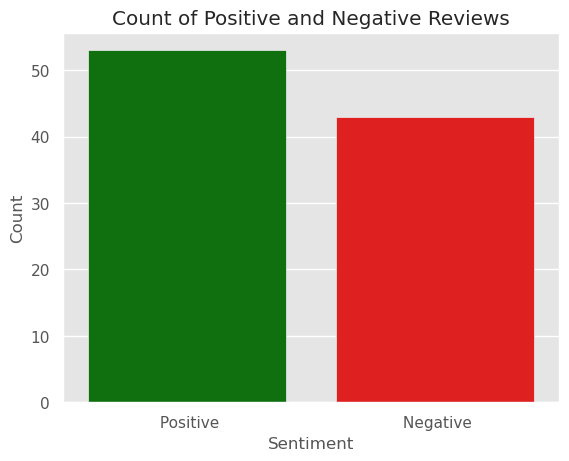

In [11]:
sns.countplot(x='Sentiment', data=data, palette= ['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Positive and Negative Reviews')
plt.show()

There are more positive reviews than the negative ones. 

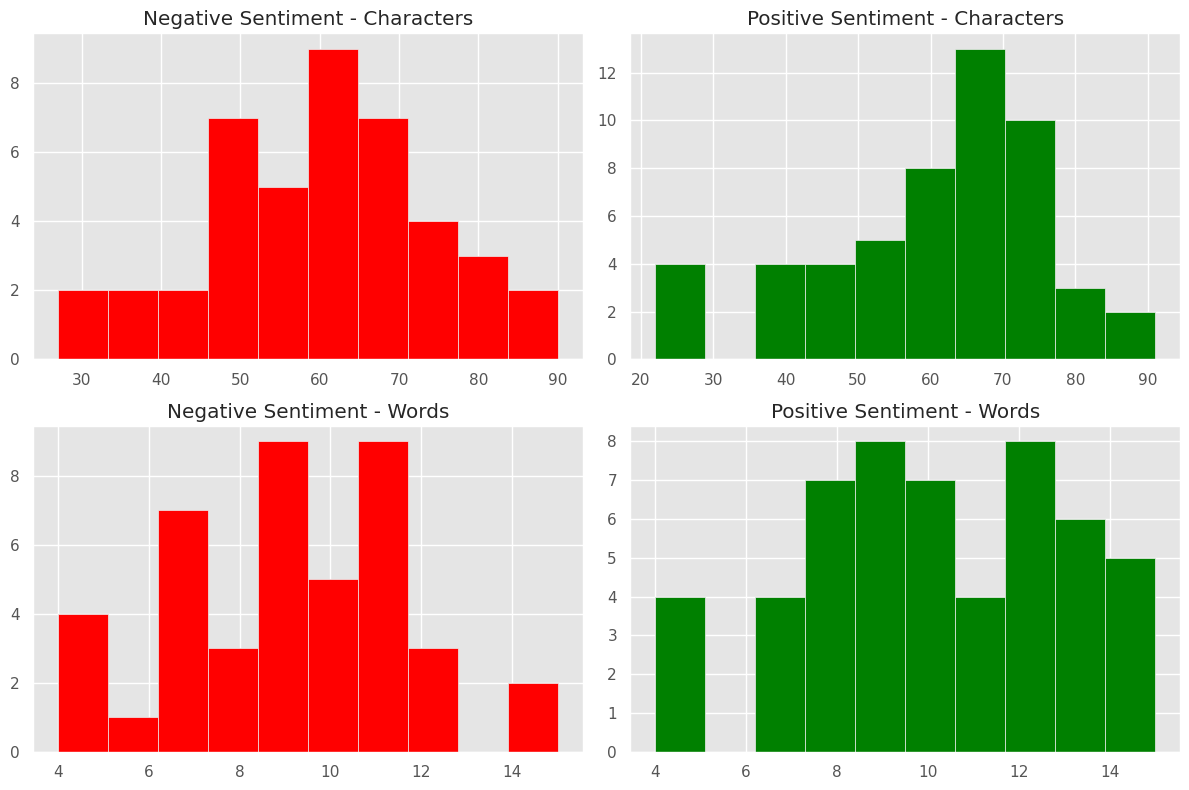

In [12]:
data['Sentiment'] = data['Sentiment'].str.strip()
data['Sentiment'] = data['Sentiment'].str.lower()


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

review_length_negative = data[data['Sentiment'] == 'negative']['Text'].str.len()
axes[0, 0].hist(review_length_negative, color='red')
axes[0, 0].set_title("Negative Sentiment - Characters")

review_length_positive = data[data['Sentiment'] == 'positive']['Text'].str.len()
axes[0, 1].hist(review_length_positive, color='green')
axes[0, 1].set_title("Positive Sentiment - Characters")

review_length_negative_words = data[data['Sentiment'] == 'negative']['Text'].str.split().map(lambda x: len(x))
axes[1, 0].hist(review_length_negative_words, color='red')
axes[1, 0].set_title("Negative Sentiment - Words")

review_length_positive_words = data[data['Sentiment'] == 'positive']['Text'].str.split().map(lambda x: len(x))
axes[1, 1].hist(review_length_positive_words, color='green')
axes[1, 1].set_title("Positive Sentiment - Words")

plt.tight_layout()

plt.show()


Negative reviews are a bit longer in terms of characters compared to positive ones, but positive reviews usually have more words. But the difference isn't that big.

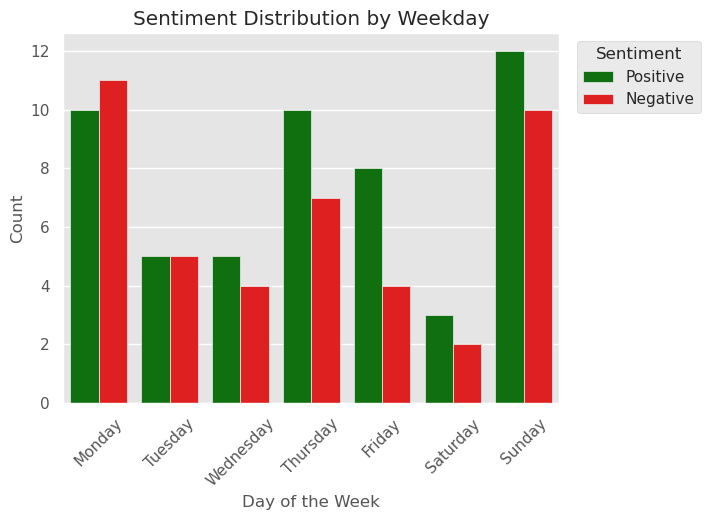

In [13]:
data['DayOfWeek'] = data['Date'].dt.day_name()
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['DayOfWeek'] = pd.Categorical(data['DayOfWeek'], categories=custom_order, ordered=True)

sns.countplot(x='DayOfWeek', hue='Sentiment', data=data, palette= ['green', 'red'])

plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.title('Sentiment Distribution by Weekday')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'], bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

Monday records the highest frequency of negative reviews.

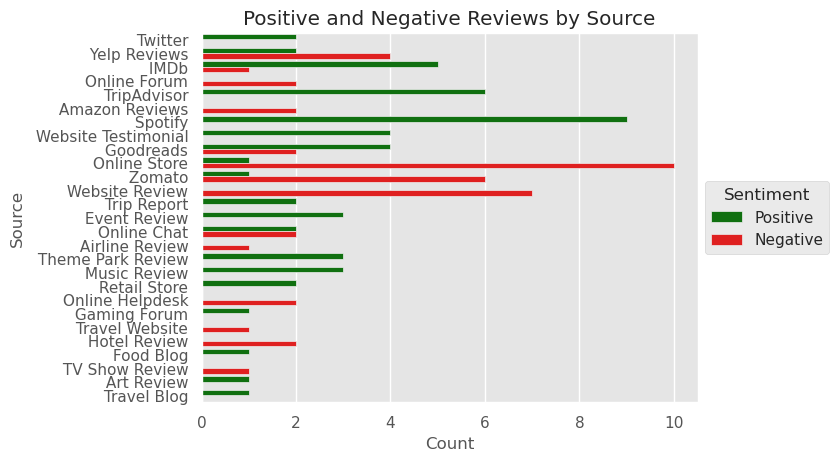

In [14]:
sns.countplot(y='Source', hue='Sentiment', data=data, palette=['green', 'red'])
plt.xlabel('Count')
plt.ylabel('Source')
plt.title('Positive and Negative Reviews by Source')
plt.legend(title='Sentiment', loc='center left', bbox_to_anchor=(1, 0.5), labels=['Positive', 'Negative'])
plt.show()

The online store received the highest level of user dissatisfaction, while Spotify emerged as the most positively reviewed source.

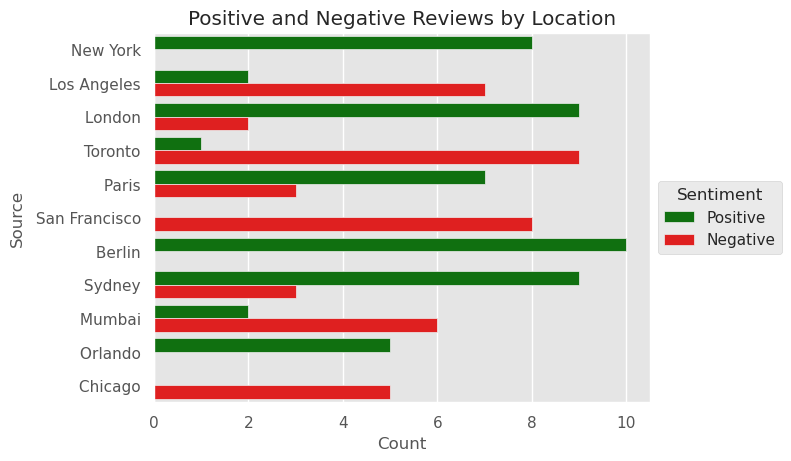

In [15]:
sns.countplot(y='Location', hue='Sentiment', data=data, palette=['green', 'red'])
plt.xlabel('Count')
plt.ylabel('Source')
plt.title('Positive and Negative Reviews by Location')
plt.legend(title='Sentiment', loc='center left', bbox_to_anchor=(1, 0.5), labels=['Positive', 'Negative'])
plt.show()

There were no positive reviews in Chicago, but Berlin and New York are cities with the most positive reviews.

# User Distribution

In [16]:
data.describe()

,Text,Sentiment,Source,User ID,Location,Confidence Score,Date,Time,DayOfWeek
count,96,96,96,96,96,96,96,96,96
unique,75,2,27,73,11,25,16,54,7
top,"""I love this product!""",positive,Online Store,user456,Sydney,0.92,2023-07-02 00:00:00,11:45:32,Sunday
freq,2,53,11,4,12,9,12,4,22
first,NaN,NaN,NaN,NaN,NaN,NaN,2023-06-15 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-17 00:00:00,NaN,NaN


There are users that gave reviews multiple times. Let's see their distribution.

In [17]:
data['User ID'] = data['User ID'].str.strip()

user_reviews = data.groupby('User ID').agg(
    ReviewCount=('Text', 'count'),
    SentimentDistribution=('Sentiment', lambda x: dict(x.value_counts()))
).reset_index()

user_reviews = user_reviews[user_reviews['ReviewCount'] >= 2]

sentiment_data = pd.DataFrame(user_reviews['SentimentDistribution'].to_list())
sentiment_data.index = user_reviews['User ID']
sentiment_data

,positive,negative
User ID,,
@user123,2.0,NaN
bookworm789,2.0,NaN
foodie22,2.0,NaN
foodlover123,NaN,2.0
foodlover2468,NaN,2.0
forumuser1,NaN,2.0
moviefan789,2.0,NaN
musiclover456,2.0,NaN
musiclover789,2.0,NaN


User 'user456' gave four negative reviews.

In [18]:
data[data['User ID'] == 'user456'][['Text', 'Source']]

,Text,Source
1,"""The service was terrible.""",Yelp Reviews
9,"""The customer service was terrible.""",Yelp Reviews
80,"""The service was terrible.""",Yelp Reviews
88,"""The customer service was terrible.""",Yelp Reviews


They are very dissatisfied with the customer service. 


# Stopwords and Punctuaction

In [19]:
def create_corpus(sentiment):
    corpus=[]
    for x in data[data['Sentiment']==sentiment]['Text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


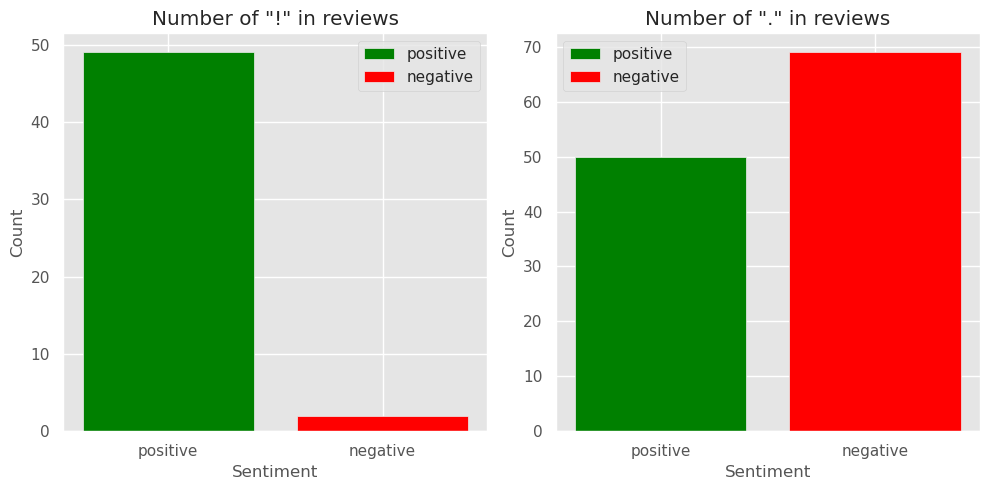

In [20]:
def count_punctuation_marks(sentiment, punctuation):
    count = 0
    for text in data[data['Sentiment'] == sentiment]['Text']:
        count += text.count(punctuation)
    return count

def plot_punctuation_counts():
    punctuations = ['!', '.']
    sentiments = ['positive', 'negative']
    colors = ['green', 'red']

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for idx, punctuation in enumerate(punctuations):
        for sentiment, color in zip(sentiments, colors):
            count = count_punctuation_marks(sentiment, punctuation)
            axes[idx].bar(sentiment, count, color=color)
        
        axes[idx].set_xlabel('Sentiment')
        axes[idx].set_ylabel('Count')
        axes[idx].set_title(f'Number of "{punctuation}" in reviews')
        axes[idx].legend(sentiments)

    plt.tight_layout()

plot_punctuation_counts()
plt.show()


When a review ends with an exclamation mark, it is usually a positive one.

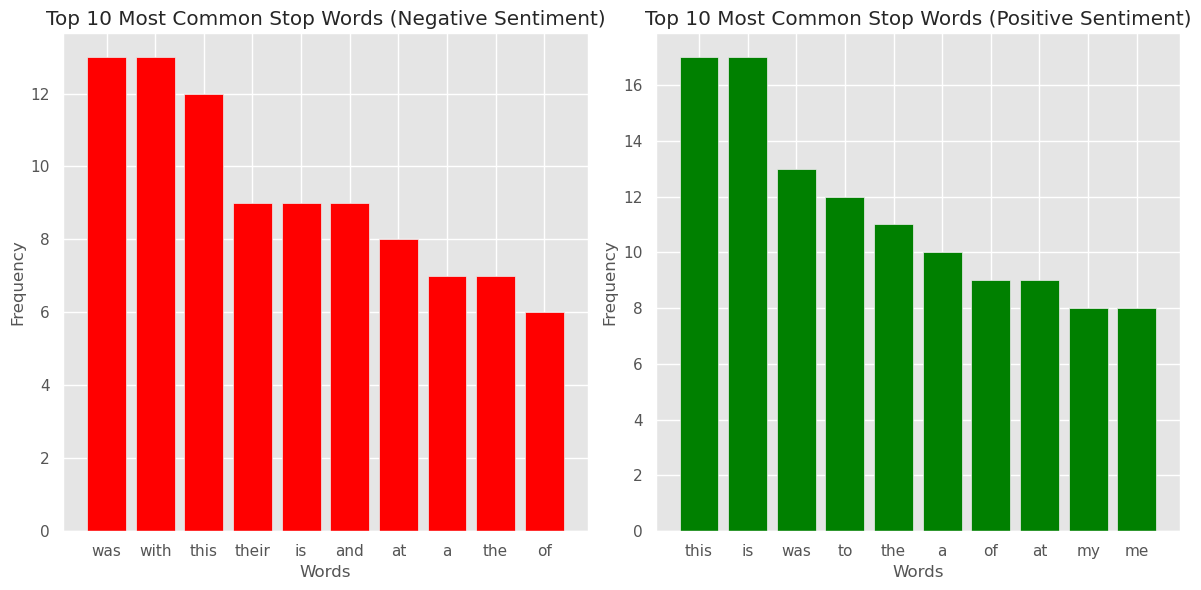

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

corpus_negative = create_corpus('negative')
dic_negative = defaultdict(int)
for word in corpus_negative:
    if word in stop:
        dic_negative[word] += 1
top_negative = sorted(dic_negative.items(), key=lambda x: x[1], reverse=True)[:10]
x_neg, y_neg = zip(*top_negative)
axes[0].bar(x_neg, y_neg, color='red')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Top 10 Most Common Stop Words (Negative Sentiment)')

corpus_positive = create_corpus('positive')
dic_positive = defaultdict(int)
for word in corpus_positive:
    if word in stop:
        dic_positive[word] += 1
top_positive = sorted(dic_positive.items(), key=lambda x: x[1], reverse=True)[:10]
x_pos, y_pos = zip(*top_positive)
axes[1].bar(x_pos, y_pos, color='green')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Top 10 Most Common Stop Words (Positive Sentiment)')

plt.tight_layout()
plt.show()


Users who provided positive reviews frequently used words like "my" and "me," while users with negative experiences tended to use the word "their" more often. Maybe satisfied users are often focused on expressing their personal feelings and experiences, and dissatisfied users directed their attention towards discussing the service or product.

# The Most Common Words

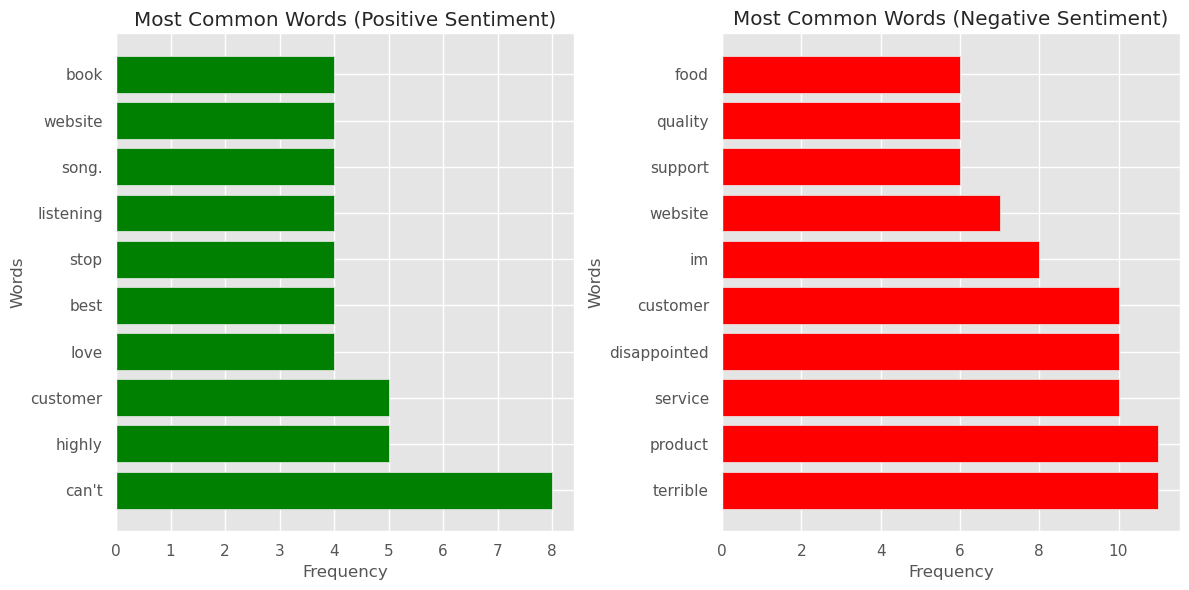

In [22]:
data['Text'] = data['Text'].str.strip('"')
def plot_most_common_words(corpus, sentiment, color):
    data['Text'] = data['Text'].str.replace(r'[{}]'.format(string.punctuation), '')
    word_freq = defaultdict(int)
    special_chars = string.punctuation
    for word in corpus:
        word = word.lower()  
        if word not in stop and word not in special_chars:
            word_freq[word] += 1

    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:10]
    x, y = zip(*top_words)

    plt.barh(x, y, color=color)  
    plt.ylabel('Words')          
    plt.xlabel('Frequency')      
    plt.title(f'Most Common Words ({sentiment.capitalize()} Sentiment)')

corpus_positive = create_corpus('positive')
plt.subplot(1, 2, 1)
plot_most_common_words(corpus_positive, 'positive', 'green')

corpus_negative = create_corpus('negative')
plt.subplot(1, 2, 2)
plot_most_common_words(corpus_negative, 'negative', 'red')
plt.subplots_adjust(wspace=0.5)  

plt.gcf().set_size_inches(12, 6)
plt.tight_layout()
plt.show()


Although "customer" appears in both negative and positive reviews, its occurrence is twice as frequent in negative reviews.

# Word Clouds

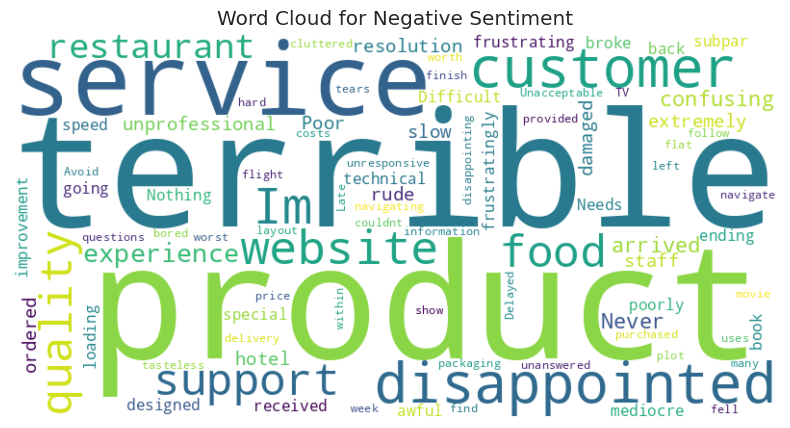

In [23]:
from wordcloud import WordCloud, STOPWORDS

def plot_word_cloud(sentiment):
    corpus = create_corpus(sentiment)
    stopwords = set(STOPWORDS)
    special_chars = set(string.punctuation)
    custom_stopwords = set(['would', 'could', 'should', 'might', 'will', 'can', 'must']) 

    all_stopwords = stopwords.union(special_chars).union(custom_stopwords)

    wordcloud = WordCloud(width=800, height=400, stopwords=all_stopwords, background_color='white').generate(' '.join(corpus))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment')
    plt.show()

plot_word_cloud('negative')


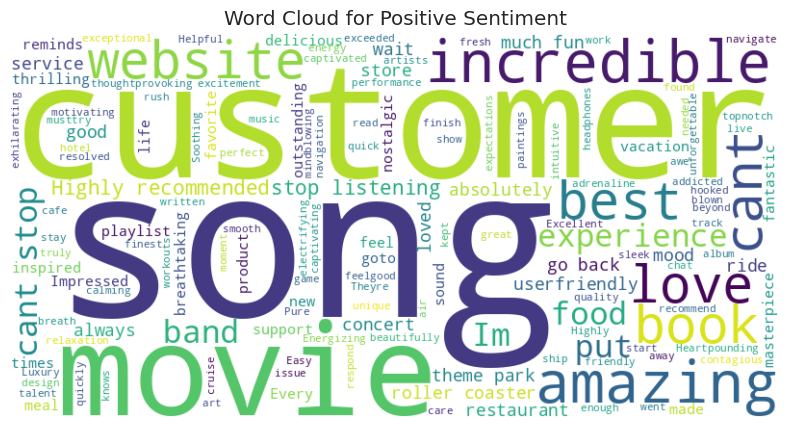

In [24]:
plot_word_cloud('positive')